In [1]:
import numpy as np
import mne
from tqdm import tqdm
from ARMA import ARMA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Data Loading

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/' 
case = 'chb01/'
preictal_filenames = ['chb01_03_preictal.npy', 'chb01_04_preictal.npy', 'chb01_15_preictal.npy', 'chb01_16_preictal.npy',
             'chb01_18_preictal.npy', 'chb01_26_preictal.npy']
interictal_filenames = ['chb01_01.edf', 'chb01_02.edf', 'chb01_05.edf',
                        'chb01_06.edf', 'chb01_07.edf', 'chb01_08.edf']

In [3]:
def load_EEG(filepath, label) -> (np.ndarray, np.ndarray):
    if label == 'preictal':
        data = np.load(filepath)
        target = np.ones(data.shape[1])
    if label == 'interictal':
        data = mne.io \
        .read_raw_edf(input_fname=filepath, preload=False, verbose='Error') \
        .get_data(picks='all', units='uV', return_times=False)
        target = -1 * np.ones(data.shape[1])
    return data, target

In [4]:
# ARMA parameters
seed = 42
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = 23                 # Number of EEG electrodes (channels)
m = 30                   # MA parameter
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')
ar = ARMA(window_width=N, order=n_i, memory=m, seed=seed)

Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [5]:
# load preictal and interictal data
preictal_feature_list = []
interictal_feature_list = []
for i in range(6):
    # load preictal data
    p_filepath = root + case + preictal_filenames[i]
    p_data, _ = load_EEG(p_filepath, 'preictal')
    # generate preictal features
    _, _, preictal_features = ar.spin(sig=p_data, fs=256)
    # load interictal data
    ic_filepath = root + case + interictal_filenames[i]
    ic_data, _ = load_EEG(ic_filepath, 'interictal')
    # generate interictal features
    _, _, interictal_features = ar.spin(sig=ic_data[:,:p_data.shape[1]], fs=256)
    
    # store data in list
    preictal_feature_list.append(preictal_features)
    interictal_feature_list.append(interictal_features)

100%|██████████| 229887/229887 [00:02<00:00, 94690.55it/s] 


## Model Training

In [6]:
ch = 0
scaler = StandardScaler() # remove mean, unit variance
preictal_features_scaled = scaler.fit_transform(preictal_feature_list[0][:,ch,:])
interictal_features_scaled = scaler.fit_transform(interictal_feature_list[0][:,ch,:])
print(preictal_features_scaled.shape, interictal_features_scaled.shape)

(449, 2) (449, 2)


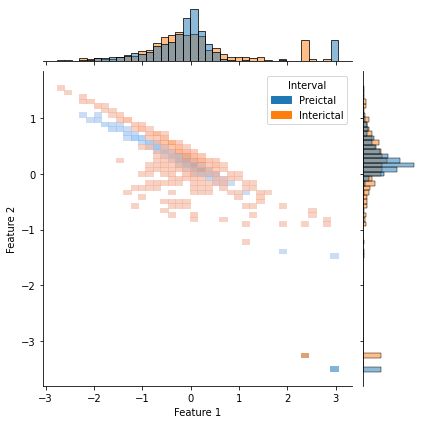

In [7]:
df = pd.DataFrame(preictal_features_scaled, columns=['Feature 1', 'Feature 2'])
df['Interval'] = 'Preictal'
df_2 = pd.DataFrame(interictal_features_scaled, columns=['Feature 1', 'Feature 2'])
df_2['Interval'] = 'Interictal'
frames = [df, df_2]
rdf = pd.concat(frames)

# visualise distribution
sns.jointplot(data=rdf, x='Feature 1', y='Feature 2', hue='Interval', kind='hist', alpha=0.6)
plt.show()

In [8]:
X = np.concatenate((interictal_features_scaled, preictal_features_scaled))

interictal_targets = -1 * np.ones(interictal_features_scaled.shape[0])
preictal_targets = np.ones(preictal_features_scaled.shape[0])
y = np.hstack((interictal_targets, preictal_targets))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_mean = np.mean(X, axis=1).reshape(-1,1)

In [9]:
X_mean.shape

(898, 1)

In [10]:
svc = SVC(kernel='rbf', C=11, gamma=7, probability=True)
svc.fit(X_mean, y)
# y_pred = svc.predict(X_mean)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))
# confuse = confusion_matrix(y_test, y_pred)
# ax = sns.heatmap(confuse, annot=True, cmap='Blues')
# ax.set_xticklabels(["Interictal", "Preictal"])
# ax.set_yticklabels(["Interictal", "Preictal"])
# ax.set_xlabel('Predicted')
# ax.set_ylabel('Ground Truth')
# plt.show()

SVC(C=11, gamma=7, probability=True)

## Model Testing

In [11]:
filepath = root + case + preictal_filenames[1]
preictal_data, preictal_target = load_EEG(filepath, 'preictal')
print(preictal_data.shape, preictal_target.shape)

filepath = root + case + interictal_filenames[1]
interictal_data, interictal_target = load_EEG(filepath, 'interictal')
print(interictal_data.shape, interictal_target)

X = np.concatenate((interictal_data, preictal_data), axis=1)
print(X.shape)

(23, 230401) (230401,)
(23, 921600) [-1. -1. -1. ... -1. -1. -1.]
(23, 1152001)


In [31]:
# online prediction
np.random.seed(42)
n_samples = X.shape[1]                  # Length of input signal
e = X                                   # Feed input signal
a = 1.8 * np.random.randn(n_c, n_i)       # Initialise AR coefficients
c = m*np.ones(m)                          # Initialise MA coefficients
c = c/c.sum()

k = np.zeros(1)
Ik = N                                    # Set window width
ar_index_list = []                        # Sequential buffer of time index
ar_hats_list = []                         # Sequential buffer of AR coefficients (conisder replacing these with vstack)
a_ma_list = []
model_1_proba_list = []
model_2_proba_list = []
mean_pred_list = []
for t in range(Ik + n_i, n_samples):      # Moving window starting from index 1 to (n_samples-1)
    if (t % N == 0):                      # Decimation policy: a is computed once every N samples
        window_start = t - Ik - n_i + 1
        window_end = t 
        a_hat = np.zeros((n_c, n_i))
        phi = np.zeros((n_c, n_i))
        for i in range(n_c):                          # Iterate electrodes
            x_t = e[i, window_start:window_end]       # Multi-channel window over input signal
            N_window = len(x_t)
            ymat = np.zeros((N_window-n_i, n_i))
            yb = np.zeros((N_window-n_i, n_i))
            
            for _c in range(n_i, 0, -1):
                ymat[:, n_i-_c] = x_t[n_i-_c:-_c]
            
            yb = x_t[n_i:]
            a_hat[i] = np.linalg.pinv(ymat) @ yb
        
        a_ma = np.zeros((n_c, n_i))
        ar_hats_k = len(ar_hats_list)-1               # Index to most recent block of AR parameters of shape: (n_c, n_i)
        for j in range(m):                            # MA smoothing of AR parameters going back m units of time, in timescale k (+1 ensures it goes up to m)
            if len(ar_hats_list) > m:                 # Only begin smoothing once unit of time passed is greater than m (MA lookback parameter) 
                a_ma = c[j] * ar_hats_list[ar_hats_k-j]
        
        a1 = a_ma[:,0]
        a2 = a_ma[:,1]
#         scaler = StandardScaler() # remove mean, unit variance
#         a1_scaled = scaler.fit_transform(a1.reshape(-1,1))
#         a2_scaled = scaler.fit_transform(a2.reshape(-1,1))
        pred_a1 = svc.predict(a1.reshape(-1,1))
        pred_a2 = svc.predict(a2.reshape(-1,1))
#         pred_a1 = svc.predict_proba(a1_scaled.reshape(-1,1))[:,1]
#         pred_a2 = svc.predict_proba(a2_scaled.reshape(-1,1))[:,1]
        pred_mean = np.mean(np.concatenate((pred_a1, pred_a2), axis=0), axis=0)
        model_1_proba_list.append(pred_a1)
        model_2_proba_list.append(pred_a2)
        mean_pred_list.append(pred_mean)
        ar_index_list.append(t)                       # Record time index of when a is computed
        ar_hats_list.append(a_hat)
        a_ma_list.append(a_ma)
                        
ar_index = np.array(ar_index_list)
ar_hats = np.array(ar_hats_list)
ars = np.array(a_ma_list)
print('Input dimension:', e.shape)
print('Output dimension:', ar_hats.shape)

Input dimension: (23, 1152001)
Output dimension: (2249, 23, 2)


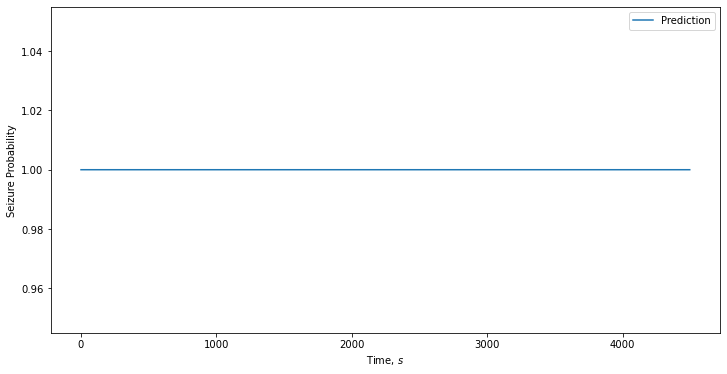

In [32]:
# only predict, unscaled
t = np.arange(0, 2249) / (256/512)
plt.figure(figsize=(12,6))
# plt.plot(t, model_1_proba_list, label='Model 1')
# plt.plot(t, model_2_proba_list, label='Model 2')
plt.plot(t, mean_pred_list, label='Prediction')
# plt.axvline(x=3600, ls='--', color='k', label='Preictal')
# plt.axhline(y=0.90, ls='--', color='r', label='Threshold')
# plt.plot(t, np.mean(np.array([model_1_proba_list, model_2_proba_list]), axis=0), label='Mean')
# plt.ylim([0.5,1])
plt.xlabel('Time, $s$')
plt.ylabel('Seizure Probability')
plt.legend()
plt.show()

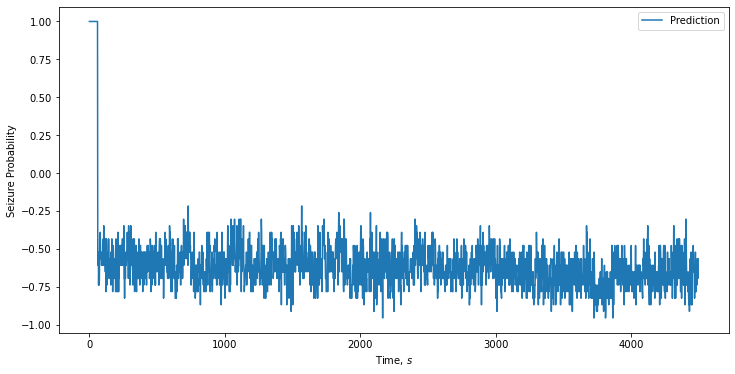

In [30]:
# only predict, scaled
t = np.arange(0, 2249) / (256/512)
plt.figure(figsize=(12,6))
# plt.plot(t, model_1_proba_list, label='Model 1')
# plt.plot(t, model_2_proba_list, label='Model 2')
plt.plot(t, mean_pred_list, label='Prediction')
# plt.axvline(x=3600, ls='--', color='k', label='Preictal')
# plt.axhline(y=0.90, ls='--', color='r', label='Threshold')
# plt.plot(t, np.mean(np.array([model_1_proba_list, model_2_proba_list]), axis=0), label='Mean')
# plt.ylim([0.5,1])
plt.xlabel('Time, $s$')
plt.ylabel('Seizure Probability')
plt.legend()
plt.show()

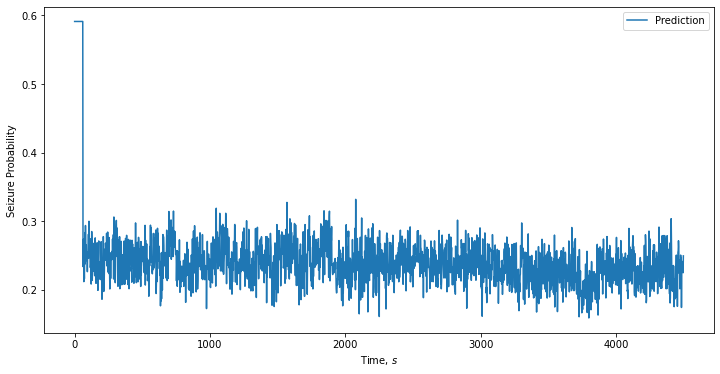

In [26]:
# predict_proba scaled
t = np.arange(0, 2249) / (256/512)
plt.figure(figsize=(12,6))
# plt.plot(t, model_1_proba_list, label='Model 1')
# plt.plot(t, model_2_proba_list, label='Model 2')
plt.plot(t, mean_pred_list, label='Prediction')
# plt.axvline(x=3600, ls='--', color='k', label='Preictal')
# plt.axhline(y=0.90, ls='--', color='r', label='Threshold')
# plt.plot(t, np.mean(np.array([model_1_proba_list, model_2_proba_list]), axis=0), label='Mean')
# plt.ylim([0.5,1])
plt.xlabel('Time, $s$')
plt.ylabel('Seizure Probability')
plt.legend()
plt.show()

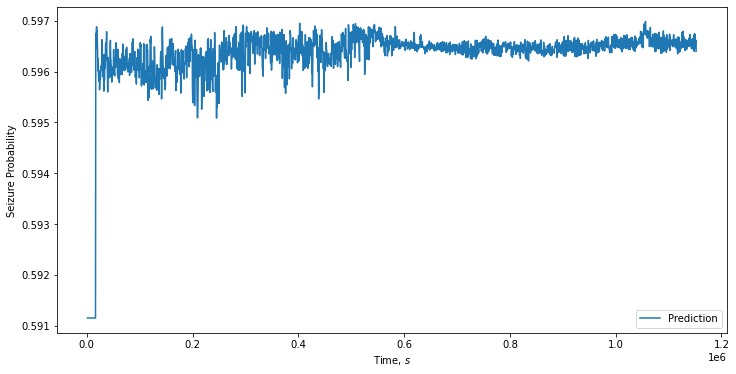

In [23]:
# predict_proba unscaled
# t = np.arange(0, 2249) / (256/512)
plt.figure(figsize=(12,6))
# plt.plot(t, model_1_proba_list, label='Model 1')
# plt.plot(t, model_2_proba_list, label='Model 2')
plt.plot(ar_index, mean_pred_list, label='Prediction')
# plt.axvline(x=3600, ls='--', color='k', label='Preictal')
# plt.axhline(y=0.90, ls='--', color='r', label='Threshold')
# plt.plot(t, np.mean(np.array([model_1_proba_list, model_2_proba_list]), axis=0), label='Mean')
# plt.ylim([0.5,1])
plt.xlabel('Time, $s$')
plt.ylabel('Seizure Probability')
plt.legend()
plt.show()

Try this with logistic regression classifier.